# Gesture Recognition using CNN
In this group project, we are build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [1]:
# Importing basic libraries to get started
import os
import datetime
import numpy as np

from skimage.io import imread
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from keras import  backend as K

# Below command depends upon terraform version
# tf.random.set_seed(30)
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
# Importing required Model libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras import optimizers

## Reading and Understanding Data

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc   = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10

print("Size of  Training  Data", len(train_doc))
print("Size of Validation Data", len(val_doc))

Size of  Training  Data 663
Size of Validation Data 100


In [ ]:
image = imread("Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00022.png")
print(image.shape)

r_image = resize(image,(100,100,3))
r1_image = resize(image,(120,120,3))
c_image = crop(image, ((50, 100), (50, 50), (0,0)), copy=False)

fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(15)
ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(r_image, cmap='gray')
ax[1].set_title("Resize image")

ax[2].imshow(r1_image, cmap='gray')
ax[2].set_title("Resize image x120")

ax[3].imshow(c_image, cmap='gray')
ax[3].set_title("Cropped image")

(360, 360, 3)


Text(0.5, 1.0, 'Cropped image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Std-dev Mean Normalisation')

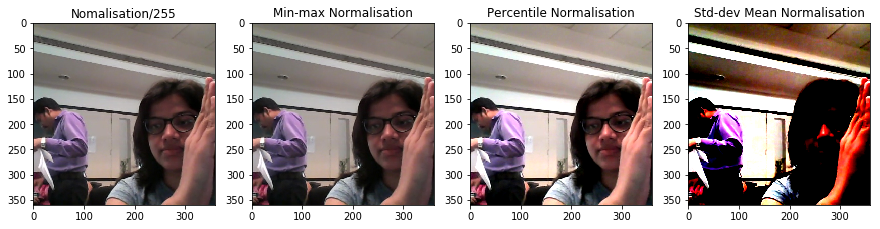

In [6]:
norm1_image = image/255
norm2_image = (image - np.min(image))/(np.max(image) - np.min(image))
norm3_image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
norm4_image = (image - np.mean(image))/np.std(image)

fig, axes = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(15)
ax = axes.ravel()

ax[0].imshow(norm1_image, cmap='gray')
ax[0].set_title("Nomalisation/255")

ax[1].imshow(norm2_image, cmap='gray')
ax[1].set_title("Min-max Normalisation")

ax[2].imshow(norm3_image, cmap='gray')
ax[2].set_title("Percentile Normalisation")

ax[3].imshow(norm4_image, cmap='gray')
ax[3].set_title("Std-dev Mean Normalisation")

### Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [5]:
# x is the number of images you use for each video, 
# (y,z) is the final size of the input images and 3 is the number of channels RGB
x = 30  # number of frames
y = 120 # image width
z = 120 # image height
classes = 5

# Generator for model sample.
def generator(source_path, folder_list, batch_size):
    print("source path = ",source_path, " batch size= ", batch_size)
    
    img_idx = [x for x in range(0,x)]
    while True:
        t = np.random.permutation( folder_list )

        # Calculate number of batches
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches):
            batch_data  = np.zeros((batch_size,x,y,z,3))
            # batch_labels is the one hot representation of the output
            batch_labels= np.zeros((batch_size,classes)) 
            for folder in range(batch_size):
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # crop the images and resize them. Note that the images are of 2 different shape 
                    #  and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = resize(image,(y,z,3))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    batch_data[folder,idx] = temp #normalise and feed in the image
#                     batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/ (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))
#                     batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/ (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
#                     batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/ (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        # code for remaining batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    temp = resize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx] = temp

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path   = 'Project_data/val'

num_train_sequences = len( train_doc )
num_val_sequences   = len( val_doc )
print('# training sequences   =', num_train_sequences)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 #choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences   = 663
# validation sequences = 100
# epochs = 10


In [7]:
# Importing Model Libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

### Sample model to start and modify along

In [8]:
def print_input_parm():
    print('# epochs =', num_epochs)
    print('# batch size =', batch_size)
    print("Size of  Training  Data", len(train_doc))
    print("Size of Validation Data", len(val_doc))
    print("No of frames in train data", x)
    print("Height of Input image", y)
    print("Width  of Input image", z)
    
print_input_parm()

# epochs = 10
# batch size = 10
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 120
Width  of Input image 120


### Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
model_a = Sequential()

model_a.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(x, y, z, 3), padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))
#Flatten Layers
model_a.add(Flatten())

model_a.add(Dense(1000, activation='relu'))
model_a.add(Dropout(0.5))

model_a.add(Dense(500, activation='relu'))
model_a.add(Dropout(0.5))

#softmax layer
model_a.add(Dense(5, activation='softmax'))

In [18]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [20]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
csv_logger = CSVLogger('training.log', append=True)
callbacks_list = [checkpoint, LR, csv_logger]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print("# Steps per epoch  ", steps_per_epoch)
print("# validation_steps ", validation_steps)

# Steps per epoch   17
# validation_steps  3


In [22]:
model_s =model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  10
source path =  Project_data/train  batch size=  10
Epoch 1/10
67/67 [==============================] - 141s 2s/step - loss: 12.6631 - categorical_accuracy: 0.2144 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 12.73330, saving model to model_init_2020-06-2811_24_17.579627/model-00001-12.73889-0.20965-12.73330-0.21000.h5
Epoch 2/10
67/67 [==============================] - 43s 636ms/step - loss: 12.6699 - categorical_accuracy: 0.2139 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 12.73330
Epoch 3/10
67/67 [==============================] - 48s 718ms/step - loss: 12.5096 - categorical_accuracy: 0.2239 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 12.73330

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
67/67 [==============================] - 

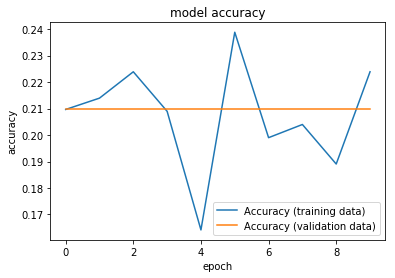

In [23]:
# visualise training history
# plt.plot(model_s.history['loss'],                     label='Categorical crossentropy (training data)')
# plt.plot(model_s.history['val_loss'],                 label='Categorical crossentropy (validation data)')
plt.plot(model_s.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_s.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

### Model 2 - Change Architecture
Sample model shows improvement in Training Data but does not performed well on validation data, let try to change arcticture.
Change architecture as compared to Model 1

Changes:-
- Using multiple convolutional layers and then max pooling.

In [25]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
channel=3
# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(classes, activation='softmax'))

model_b.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 30, 120, 120, 32)  27680     
_________________________________________________________________
activation_6 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 40, 40, 32)    0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 40, 40, 32)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 40, 40, 64)    55360     
__________

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_2 = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  10
source path =  Project_data/train  batch size=  10
Epoch 1/10
67/67 [==============================] - 155s 2s/step - loss: 1.7305 - categorical_accuracy: 0.2060 - val_loss: 1.6013 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from 12.73330 to 1.60134, saving model to model_init_2020-06-2811_24_17.579627/model-00001-1.73182-0.20814-1.60134-0.23000.h5
Epoch 2/10
67/67 [==============================] - 50s 748ms/step - loss: 1.6087 - categorical_accuracy: 0.1891 - val_loss: 1.5673 - val_categorical_accuracy: 0.3600

Epoch 00002: val_loss improved from 1.60134 to 1.56734, saving model to model_init_2020-06-2811_24_17.579627/model-00002-1.60872-0.18905-1.56734-0.36000.h5
Epoch 3/10
67/67 [==============================] - 51s 765ms/step - loss: 1.6098 - categorical_accuracy: 0.2388 - val_loss: 1.6096 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.56734
Epoch 4/10
67/67 [================

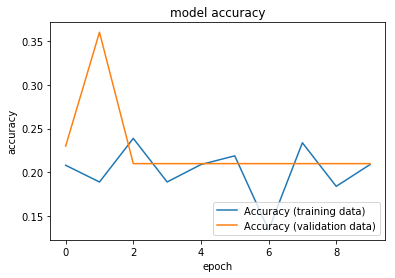

In [29]:
plt.plot(model_2.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_2.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

Again validation data becomes consistent after 2 runs only. Lets try to make changes to other parameter and see how it will impact using the same architecture.

### Model 3 - Changing Image Height and Width

In [23]:
x = 30 # number of frames
y = 60 # image width
z = 60 # image height
channel=3
print_input_parm()

# epochs = 10
# batch size = 10
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 60
Width  of Input image 60


In [24]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(classes, activation='softmax'))

model_b.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 20, 20, 64)    55360     
__________

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
model_3 = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  10
source path =  Project_data/train Epoch 1/10 batch size=  10

67/67 [==============================] - 208s 3s/step - loss: 1.6413 - categorical_accuracy: 0.1985 - val_loss: 1.6070 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 1.60696, saving model to model_init_2020-06-2907_32_45.453379/model-00001-1.64164-0.20060-1.60696-0.18000.h5
Epoch 2/10
67/67 [==============================] - 36s 531ms/step - loss: 1.6111 - categorical_accuracy: 0.2040 - val_loss: 1.6125 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.60696
Epoch 3/10
67/67 [==============================] - 34s 511ms/step - loss: 1.6056 - categorical_accuracy: 0.2488 - val_loss: 1.6109 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.60696

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
67/67 [==============================] - 37s 557ms/s

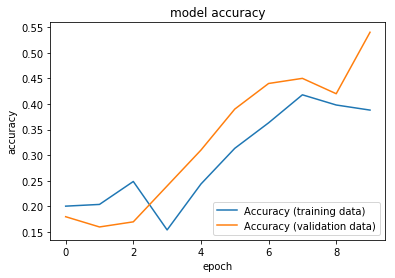

In [28]:
plt.plot(model_3.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_3.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

Validation accuracy is more than training data which indicates weak training data. Lets increase batch size

### Model 4 - Changing Batch Size

In [29]:
batch_size = 20
print_input_parm()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# epochs = 10
# batch size = 20
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 60
Width  of Input image 60


In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [33]:
model_4 = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
34/34 [==============================] - 24s 695ms/step - loss: 0.9058 - categorical_accuracy: 0.6373 - val_loss: 0.8960 - val_categorical_accuracy: 0.6000

Epoch 00001: val_loss improved from 0.94558 to 0.89605, saving model to model_init_2020-06-2907_32_45.453379/model-00001-0.90578-0.63725-0.89605-0.60000.h5
Epoch 2/10
34/34 [==============================] - 23s 687ms/step - loss: 0.8694 - categorical_accuracy: 0.6471 - val_loss: 0.9155 - val_categorical_accuracy: 0.6600

Epoch 00002: val_loss did not improve from 0.89605
Epoch 3/10
34/34 [==============================] - 25s 730ms/step - loss: 0.7297 - categorical_accuracy: 0.6667 - val_loss: 0.9123 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss did not improve from 0.89605

Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 4/10
34/34 [==============================] - 25s 721ms/step - loss: 0.7290 - categorical_accuracy: 0.7059 - val_loss: 0.9280 - val_categorical_accuracy

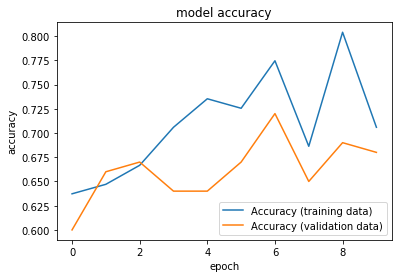

In [34]:
plt.plot(model_4.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_4.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

Model shows good sign of improvement in increasing batch size. Lets increase a bit more batch size

### Model 5 - Chaning Batch Size to 30

In [35]:
batch_size = 30
print_input_parm()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# epochs = 10
# batch size = 30
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 60
Width  of Input image 60


In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [38]:
model_5 = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  30
source path =  Project_data/train Epoch 1/10
 batch size=  30
23/23 [==============================] - 103s 4s/step - loss: 0.5805 - categorical_accuracy: 0.7668 - val_loss: 0.8870 - val_categorical_accuracy: 0.6700

Epoch 00001: val_loss did not improve from 0.83318
Epoch 2/10
23/23 [==============================] - 12s 516ms/step - loss: 0.6169 - categorical_accuracy: 0.8116 - val_loss: 0.7961 - val_categorical_accuracy: 0.7250

Epoch 00002: val_loss improved from 0.83318 to 0.79609, saving model to model_init_2020-06-2907_32_45.453379/model-00002-0.61693-0.81159-0.79609-0.72500.h5
Epoch 3/10
23/23 [==============================] - 14s 587ms/step - loss: 0.4847 - categorical_accuracy: 0.8696 - val_loss: 0.9782 - val_categorical_accuracy: 0.6750

Epoch 00003: val_loss did not improve from 0.79609
Epoch 4/10
23/23 [==============================] - 13s 546ms/step - loss: 0.4175 - categorical_accuracy: 0.8696 - val_loss: 0.8528 - val_ca

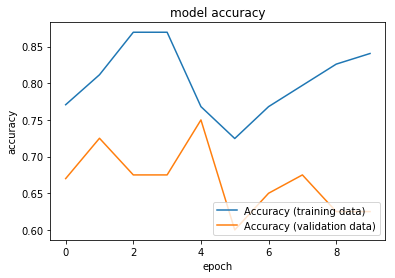

In [39]:
plt.plot(model_5.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_5.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

### Model 6 - Chaning Batch Size to 40
High batches are failing with OOM error. So need to stick with low batch size.

In [40]:
batch_size = 40
print_input_parm()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# epochs = 10
# batch size = 40
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 60
Width  of Input image 60


In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [43]:
model_6 = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  40
source path =  Project_data/train Epoch 1/10
 batch size=  40
17/17 [==============================] - 115s 7s/step - loss: 0.5479 - categorical_accuracy: 0.7893 - val_loss: 0.9053 - val_categorical_accuracy: 0.6100

Epoch 00001: val_loss did not improve from 0.79609
Epoch 2/10
17/17 [==============================] - 54s 3s/step - loss: 0.5423 - categorical_accuracy: 0.8235 - val_loss: 0.9073 - val_categorical_accuracy: 0.6667

Epoch 00002: val_loss did not improve from 0.79609
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 0.5270 - categorical_accuracy: 0.7933 - val_loss: 0.7827 - val_categorical_accuracy: 0.6833

Epoch 00003: val_loss improved from 0.79609 to 0.78271, saving model to model_init_2020-06-2907_32_45.453379/model-00003-0.52309-0.79837-0.78271-0.68333.h5
Epoch 4/10
17/17 [==============================] - 50s 3s/step - loss: 0.5200 - categorical_accuracy: 0.7740 - val_loss: 1.0034 - val_categorical

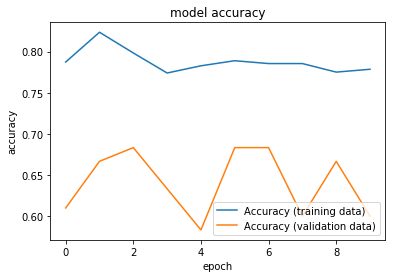

In [44]:
plt.plot(model_6.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_6.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

Model shows good accuracy of training but shows ovefitting.

### Model 7 - Changing Optimiser to Adadelta

In [45]:
model_b.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 20, 20, 64)    55360     
__________

In [48]:
model_7 = model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
17/17 [==============================] - 55s 3s/step - loss: 0.6854 - categorical_accuracy: 0.7543 - val_loss: 0.9180 - val_categorical_accuracy: 0.6167

Epoch 00001: val_loss did not improve from 0.78271
Epoch 2/10
17/17 [==============================] - 41s 2s/step - loss: 0.5691 - categorical_accuracy: 0.7924 - val_loss: 1.0579 - val_categorical_accuracy: 0.6667

Epoch 00002: val_loss did not improve from 0.78271
Epoch 3/10
17/17 [==============================] - 43s 3s/step - loss: 0.6086 - categorical_accuracy: 0.7163 - val_loss: 1.1031 - val_categorical_accuracy: 0.6167

Epoch 00003: val_loss did not improve from 0.78271

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.5.
Epoch 4/10
17/17 [==============================] - 41s 2s/step - loss: 0.4604 - categorical_accuracy: 0.8408 - val_loss: 0.8419 - val_categorical_accuracy: 0.7167

Epoch 00004: val_loss did not improve from 0.78271
Epoch 5/10
17/17 [==============================] - 41s 2s/step - loss: 0

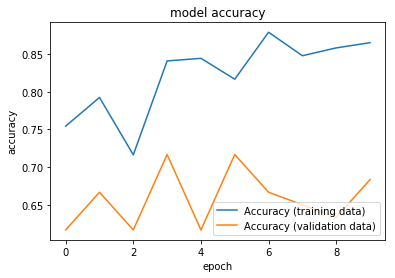

In [49]:
plt.plot(model_7.history['categorical_accuracy']    , label='Accuracy (training data)')
plt.plot(model_7.history['val_categorical_accuracy'], label='Accuracy (validation data)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

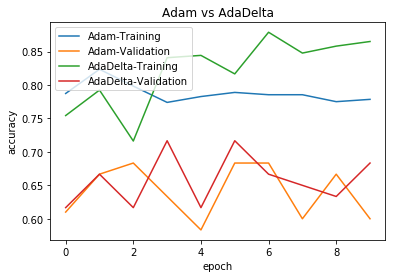

In [52]:
plt.plot(model_6.history['categorical_accuracy']    , label='Adam-Training')
plt.plot(model_6.history['val_categorical_accuracy'], label='Adam-Validation')
plt.plot(model_7.history['categorical_accuracy']    , label='AdaDelta-Training')
plt.plot(model_7.history['val_categorical_accuracy'], label='AdaDelta-Validation')
plt.title('Adam vs AdaDelta')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

# Model 8- Changing Height and Width to 100
Higher batch size shows good improvement and lets change height and width

In [9]:
batch_size = 40
y=100
z=100
print_input_parm()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

# epochs = 10
# batch size = 40
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 100
Width  of Input image 100


In [14]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(x,y,z,3)

# Define model
model_cnn = Sequential()

model_cnn.add(Conv3D(nb_filters[0], kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))

model_cnn.add(MaxPooling3D(pool_size=(2,2,2)))
model_cnn.add(Conv3D(nb_filters[1], kernel_size=(3,3,3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))

model_cnn.add(MaxPooling3D(pool_size=(2,2,2)))
model_cnn.add(Conv3D(nb_filters[2], kernel_size=(1,3,3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))

model_cnn.add(MaxPooling3D(pool_size=(2,2,2)))

model_cnn.add(Conv3D(nb_filters[3], kernel_size=(1,3,3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.25))

model_cnn.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_cnn.add(Flatten())

model_cnn.add(Dense(nb_dense[0], activation='relu'))
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(nb_dense[1], activation='relu'))
model_cnn.add(Dropout(0.5))

#softmax layer
model_cnn.add(Dense(nb_dense[2], activation='softmax'))

model_cnn.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 100, 100, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 50, 50, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 50, 50, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 50, 50, 16)    0         
__________

In [15]:
model_cnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  40
source path =  Project_data/train  batch size=  40
Epoch 1/10
Batch:  3 Index: 40
17/17 [==============================] - 236s 14s/step - loss: 2.0546 - categorical_accuracy: 0.2413 - val_loss: 1.5125 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 1.51252, saving model to model_init_2020-06-3001_40_33.175432/model-00001-2.06758-0.23982-1.51252-0.27000.h5
Epoch 2/10
17/17 [==============================] - 74s 4s/step - loss: 1.5015 - categorical_accuracy: 0.3171 - val_loss: 1.4569 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss improved from 1.51252 to 1.45690, saving model to model_init_2020-06-3001_40_33.175432/model-00002-1.50151-0.31714-1.45690-0.25000.h5
Epoch 3/10
17/17 [==============================] - 70s 4s/step - loss: 1.3315 - categorical_accuracy: 0.4110 - val_loss: 1.2666 - val_categorical_accuracy: 0.3167

Epoch 00003: val_loss improved from 1.45690 to 1.26663, saving model to mod

# CNN + RNN(LSTM) Model



In [9]:
print_input_parm()

# epochs = 10
# batch size = 10
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 120
Width  of Input image 120


In [15]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, LSTM
model = Sequential()
model.add( TimeDistributed(Conv2D(32, (3, 3), padding='same'),input_shape=(x,y,z,3)) )
model.add( Activation('relu'))
model.add( TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add( Dropout(0.25))
model.add( TimeDistributed(Flatten()))

model.add(LSTM(128, dropout=1.0))
model.add(Dense(5, activation = "softmax"))

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 30, 120, 120, 32)  896       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 115200)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               59048448  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total para

In [16]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
csv_logger = CSVLogger('training.log', append=True)
callbacks_list = [checkpoint, LR, csv_logger]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print("# Steps per epoch  ", steps_per_epoch)
print("# validation_steps ", validation_steps)

# Steps per epoch   67
# validation_steps  10


In [19]:
model_r1 =model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  10
source path =  Project_data/train  batch size=  10
Epoch 1/10
67/67 [==============================] - 248s 4s/step - loss: 1.7026 - categorical_accuracy: 0.2329 - val_loss: 1.6148 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 1.61482, saving model to model_init_2020-06-3000_22_40.770037/model-00001-1.70303-0.23529-1.61482-0.22000.h5
Epoch 2/10
67/67 [==============================] - 58s 863ms/step - loss: 1.5985 - categorical_accuracy: 0.2637 - val_loss: 1.6574 - val_categorical_accuracy: 0.2800

Epoch 00002: val_loss did not improve from 1.61482
Epoch 3/10
67/67 [==============================] - 56s 842ms/step - loss: 1.6384 - categorical_accuracy: 0.2189 - val_loss: 1.6109 - val_categorical_accuracy: 0.1900

Epoch 00003: val_loss improved from 1.61482 to 1.61089, saving model to model_init_2020-06-3000_22_40.770037/model-00003-1.63836-0.21891-1.61089-0.19000.h5
Epoch 4/10
67/67 [=====================

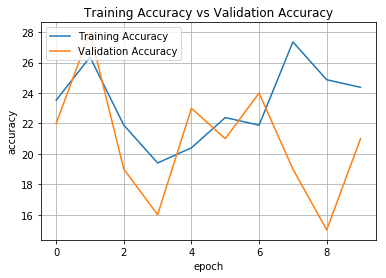

In [24]:
plt.plot(np.array(model_r1.history['categorical_accuracy'])*100   , label='Training Accuracy')
plt.plot(np.array(model_r1.history['val_categorical_accuracy'])*100, label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.grid(b=True, which='both')
# help(plt.grid)
plt.show()

In [20]:
num_epochs=20
batch_size=20

print_input_parm()
# Let us create the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print("# Steps per epoch  ", steps_per_epoch)
print("# validation_steps ", validation_steps)

# epochs = 20
# batch size = 20
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 120
Width  of Input image 120
# Steps per epoch   34
# validation_steps  5


In [21]:
# from keras.layers import GRU

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

lstm = Sequential()
lstm.add(TimeDistributed(model, input_shape=(x,y,z,3)))

lstm.add(LSTM(128, dropout=1.0))
lstm.add(Dense(5, activation = "softmax"))

optimiser = 'adam'
lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 30, 50176)         65568     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               25756160  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 25,822,373
Trainable params: 25,822,373
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
rnn1 =lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  20
source path =  Project_data/train  batch size=  20
Epoch 1/20
34/34 [==============================] - 150s 4s/step - loss: 1.6865 - categorical_accuracy: 0.2634 - val_loss: 1.5439 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from 1.58276 to 1.54389, saving model to model_init_2020-06-3000_22_40.770037/model-00001-1.67286-0.26998-1.54389-0.26000.h5
Epoch 2/20
34/34 [==============================] - 28s 829ms/step - loss: 1.4422 - categorical_accuracy: 0.3627 - val_loss: 1.4864 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss improved from 1.54389 to 1.48644, saving model to model_init_2020-06-3000_22_40.770037/model-00002-1.44222-0.36275-1.48644-0.40000.h5
Epoch 3/20
34/34 [==============================] - 31s 920ms/step - loss: 1.5207 - categorical_accuracy: 0.2843 - val_loss: 1.4950 - val_categorical_accuracy: 0.3300

Epoch 00003: val_loss did not improve from 1.48644
Epoch 4/20
34/34 [=================

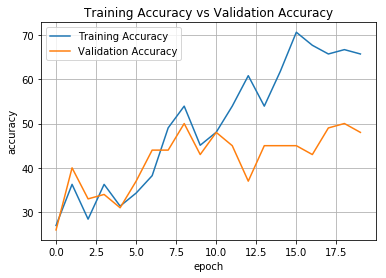

In [25]:
plt.plot(np.array(rnn1.history['categorical_accuracy'])*100   , label='Training Accuracy')
plt.plot(np.array(rnn1.history['val_categorical_accuracy'])*100, label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.grid(b=True, which='both')
# help(plt.grid)
plt.show()

CNN + RNN shows improvement after changing the architecture but tends to overfit in small epochs which shows a sign of good model but as CNN+RNN is computationally expensive, we got better results in 20 epochs in CNN3D model and with less no of parameters, so we will using CNN3D model.

In [18]:
num_epochs=20
batch_size=20
x=30
y=100
z=100
print_input_parm()
# Let us create the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print("# Steps per epoch  ", steps_per_epoch)
print("# validation_steps ", validation_steps)

# epochs = 20
# batch size = 20
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 100
Width  of Input image 100
# Steps per epoch   34
# validation_steps  5


In [23]:
from keras.applications.vgg16 import VGG16
from keras.layers import GRU

vgg = VGG16(include_top=False,weights='imagenet',input_shape=(y, z, 3))
for layer in vgg.layers[:-4]:
    layer.trainable = False

# create a Sequential model
model = Sequential()
model.add(TimeDistributed(vgg, input_shape=(x, y, z, 3)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(256, activation='relu', return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(5, activation='softmax'))
model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 4608)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               3736320   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 18,467,781
Trainable params: 10,832,517
Non-trainable params: 7,635,264
________________________________________________________

In [24]:
model_gru =model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
34/34 [==============================] - 34s 990ms/step - loss: 3.0759 - categorical_accuracy: 0.1667 - val_loss: 1.6584 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss did not improve from 0.94748
Epoch 2/20
34/34 [==============================] - 28s 826ms/step - loss: 1.7672 - categorical_accuracy: 0.1765 - val_loss: 1.6115 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 0.94748
Epoch 3/20
34/34 [==============================] - 29s 845ms/step - loss: 1.6391 - categorical_accuracy: 0.2059 - val_loss: 1.5947 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 0.94748
Epoch 4/20
34/34 [==============================] - 30s 885ms/step - loss: 1.5651 - categorical_accuracy: 0.2843 - val_loss: 1.9358 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 0.94748
Epoch 5/20
34/34 [==============================] - 30s 881ms/step - loss: 1.6757 - categorical_accuracy: 0.1863 - val_loss:

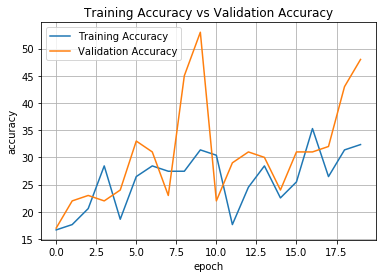

In [25]:
plt.plot(np.array(model_gru.history['categorical_accuracy'])*100   , label='Training Accuracy')
plt.plot(np.array(model_gru.history['val_categorical_accuracy'])*100, label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.grid(b=True, which='both')
# help(plt.grid)
plt.show()

# Final Model

In [10]:
batch_size = 40
num_epochs = 50
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
channel=3
print_input_parm()

# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

# epochs = 50
# batch size = 40
Size of  Training  Data 663
Size of Validation Data 100
No of frames in train data 30
Height of Input image 120
Width  of Input image 120


In [11]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(x,y,z,3)

# Define model
model_final = Sequential()

model_final.add(Conv3D(nb_filters[0], kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))
model_final.add(Conv3D(nb_filters[1], kernel_size=(3,3,3), padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))
model_final.add(Conv3D(nb_filters[2], kernel_size=(1,3,3), padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[3], kernel_size=(1,3,3), padding='same'))
model_final.add(Activation('relu'))
model_final.add(Dropout(0.25))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_final.add(Flatten())

model_final.add(Dense(nb_dense[0], activation='relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(nb_dense[1], activation='relu'))
model_final.add(Dropout(0.5))

#softmax layer
model_final.add(Dense(nb_dense[2], activation='softmax'))

In [12]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_final.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [13]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print("# Steps per epoch  ", steps_per_epoch)
print("# validation_steps ", validation_steps)

# Steps per epoch   17
# validation_steps  3


In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
csv_logger = CSVLogger('training.log', append=True)
callbacks_list = [checkpoint, LR, csv_logger]

In [17]:
model = model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  Project_data/val  batch size=  40
source path =  Project_data/train  batch size=  40Epoch 1/50

17/17 [==============================] - 146s 9s/step - loss: 2.1469 - categorical_accuracy: 0.2447 - val_loss: 1.5588 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.55884, saving model to model_init_2020-06-2912_33_57.869174/model-00001-2.16164-0.24434-1.55884-0.21000.h5
Epoch 2/50
17/17 [==============================] - 77s 5s/step - loss: 1.5269 - categorical_accuracy: 0.3299 - val_loss: 1.4620 - val_categorical_accuracy: 0.2667

Epoch 00002: val_loss improved from 1.55884 to 1.46202, saving model to model_init_2020-06-2912_33_57.869174/model-00002-1.52686-0.32992-1.46202-0.26667.h5
Epoch 3/50
17/17 [==============================] - 73s 4s/step - loss: 1.3615 - categorical_accuracy: 0.3992 - val_loss: 1.3369 - val_categorical_accuracy: 0.3333

Epoch 00003: val_loss improved from 1.46202 to 1.33690, saving model to model_init_2020-06-2912_

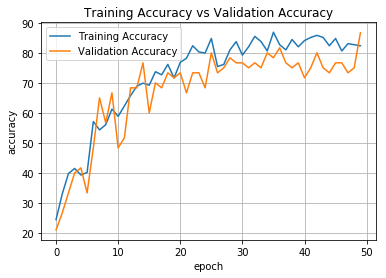

In [29]:
plt.plot(np.array(model.history['categorical_accuracy'])*100   , label='Training Accuracy')
plt.plot(np.array(model.history['val_categorical_accuracy'])*100, label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.grid(b=True, which='both')
# help(plt.grid)
plt.show()

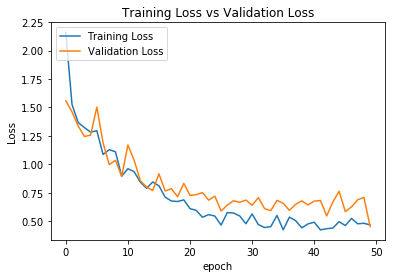

In [30]:
plt.plot(model.history['loss']    , label='Training Loss')
plt.plot(model.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

Epoch 43/50
17/17 [==============================] - 54s 3s/step - loss: 0.4336 - categorical_accuracy: 0.8581 - val_loss: 0.5459 - val_categorical_accuracy: 0.8000

Epoch 00043: val_loss improved from 0.58921 to 0.54585, saving model to **model_init_2020-06-2912_33_57.869174/model00043-0.43364-0.85813-0.54585-0.80000.h5**

**Epoch 43 runs a good model with an accuracy of 86% and validation accuracy around 78%**